In [1]:
from ibicus.debias import QuantileMapping
import xarray as xr
from pathlib import Path

from deepdown.utils.data_loader import DataLoader
from deepdown.utils.debiaser_utils import get_ibicus_var_name, prepare_for_ibicus
from deepdown.config import Config
from deepdown.bias_correction_classic import correct_bias
import matplotlib.pyplot as plt
import cartopy

from argparse import Namespace
cli_args = Namespace(config_file="../config.yaml")
config = Config(cli_args)
conf = config.config


In [24]:
dir_path = Path(conf.path_output)
input_data_clim_debiased = xr.open_dataset(dir_path / "input_data_clim_debiased.nc")
target_data_clim = xr.open_dataset(dir_path / "target_clim_period.nc")

In [25]:
target_data_clim['t'] = target_data_clim['t'] + 273.15
target_data_clim['t_max'] = target_data_clim['t_max'] + 273.15
target_data_clim['t_min'] = target_data_clim['t_min'] + 273.15
target_data_clim['tp'] = target_data_clim['tp'] /86.400

In [26]:
# adjust the units again
input_data_clim_debiased['tp_deb']=input_data_clim_debiased['tp_deb']*86.400

In [27]:
def plot_grid_points(input_data, grid_points, variables,target_coarser =None):
    """
    Plot specified variables and their debiased versions for multiple grid points.

    Parameters:
    input_data (dict): Dictionary containing the data arrays.
    grid_points (list of tuples): List of tuples where each tuple contains (row, col) coordinates.
    variables (list of str): List of variable names to plot.
    """
    num_rows = len(grid_points)
    num_cols = len(variables)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16*num_cols, 12*num_rows), squeeze=False)
    
    for i, (row, col) in enumerate(grid_points):
        for j, var in enumerate(variables):
            ax = axes[i, j]
            var_deb = f"{var}_deb"
            if var in input_data:
                input_data[var][:, row, col].plot(ax=ax,linestyle='dashed',color='red', label=f'{var} ({row},{col})')
            if var_deb in input_data:
                input_data[var_deb][:, row, col].plot(ax=ax, color='black',label=f'{var_deb} ({row},{col})')
            if target_coarser is not None:
                target_coarser[var][:, row, col].plot(ax=ax, color='blue',label=f'MCH{var} ({row},{col})')

                
            
            ax.set_xlabel('Time', fontsize=22)
            ax.set_ylabel(var, fontsize=22)
            ax.legend(prop=dict(size=22))

    
    plt.tight_layout()
    plt.show()



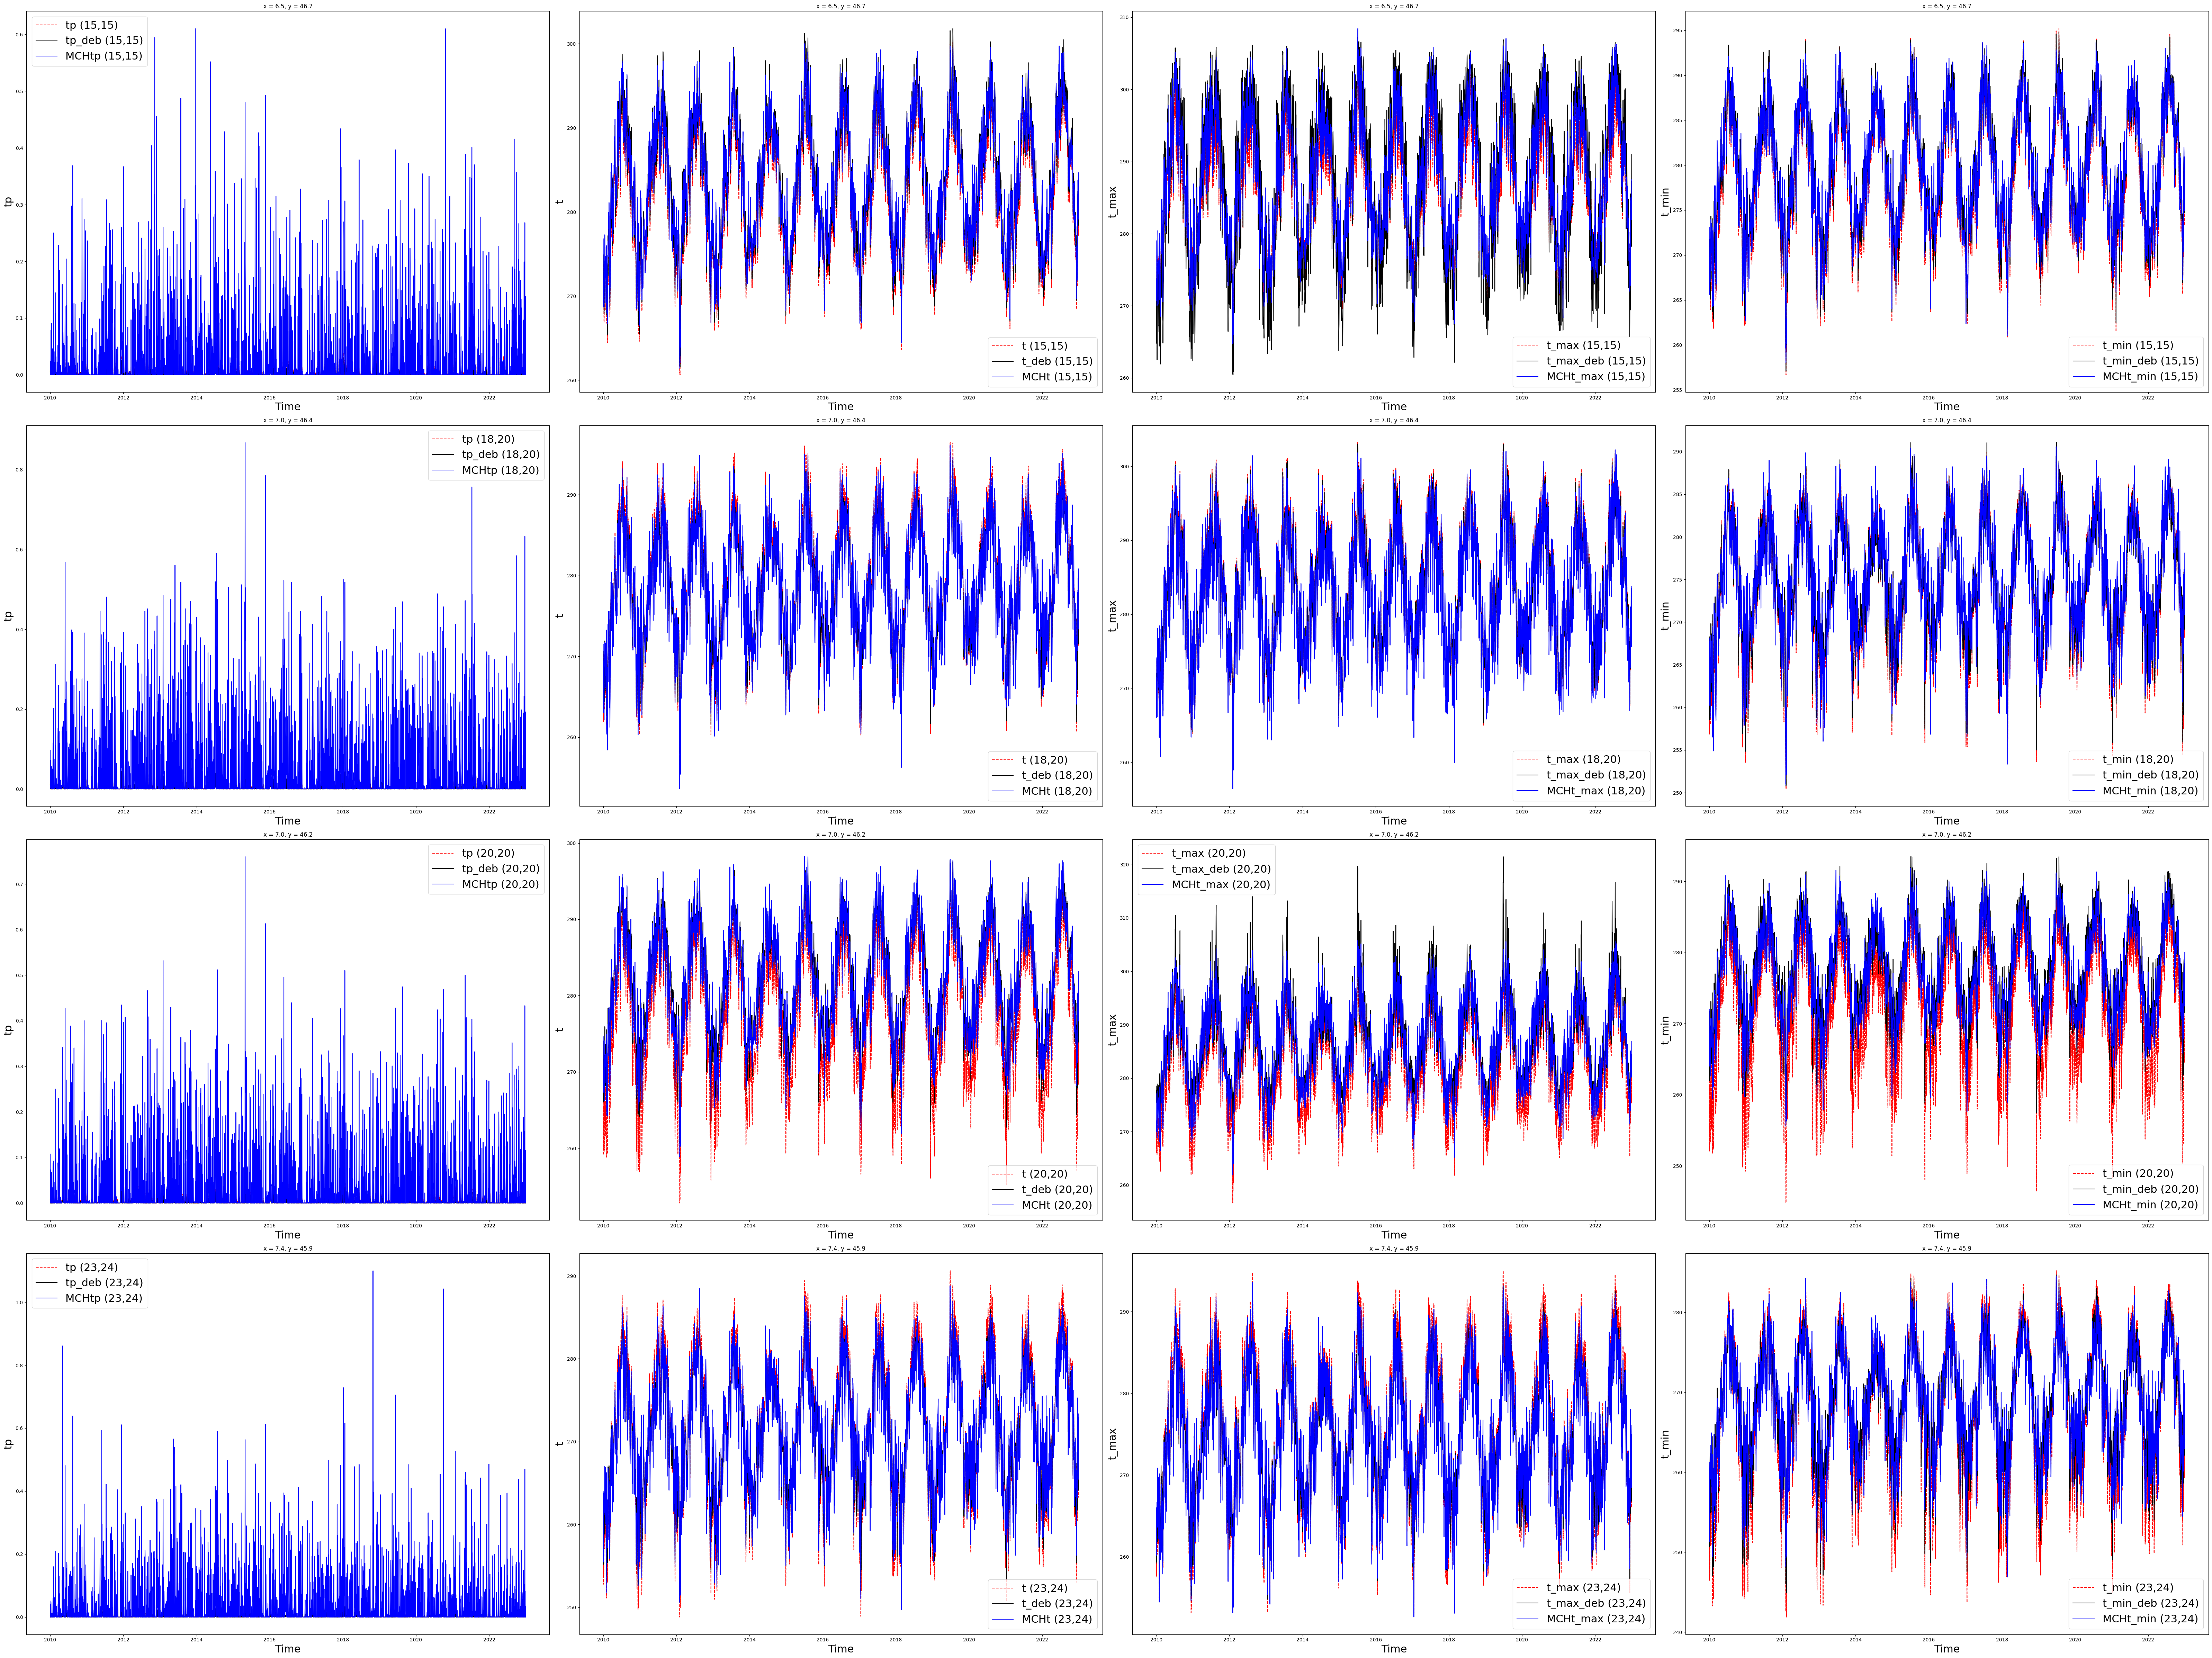

In [32]:
# Let's look at some points
grid_points = [(15,15),(18,20),(20, 20), (23, 24)]  # Example grid points
variables = ['tp', 't', 't_max', 't_min']  # Example variables

# Call the function to plot the data
plot_grid_points(input_data_clim_debiased, grid_points, variables, target_data_clim)

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_mean_maps(input_data, variables, target_coarser = None):
    """
    Plot mean maps for specified variables and their debiased versions.

    Parameters:
    input_data (dict): Dictionary containing the data arrays.
    variables (list of str): List of variable names to plot.
    """
    num_vars = len(variables)
    num_rows = num_vars
    num_cols = 3  # One for the original variable, one for the debiased variable
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    
    for i, var in enumerate(variables):
        var_deb = f"{var}_deb"
        ax_original = axes[i, 0]
        ax_debiased = axes[i, 1]
        ax_coarser = axes[i, 1]
        
        if var in input_data:
            mean_data = input_data[var].mean(dim="time")
            mean_data.plot(ax=ax_original, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})
            ax_original.add_feature(cfeature.COASTLINE)
            ax_original.add_feature(cfeature.BORDERS)
            ax_original.set_title(f'Mean {var}', fontsize=14)
        
        if var_deb in input_data:
            mean_data_deb = input_data[var_deb].mean(dim="time")
            mean_data_deb.plot(ax=ax_debiased, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})
            ax_debiased.add_feature(cfeature.COASTLINE)
            ax_debiased.add_feature(cfeature.BORDERS)
            ax_debiased.set_title(f'Mean {var_deb}', fontsize=14)

        if target_coarser is not None:
            mean_ch_coarser = target_coarser[var].mean(dim="time")
            mean_ch_coarser.plot(ax=ax_coarser, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'shrink': 0.5})
            ax_coarser.add_feature(cfeature.COASTLINE)
            ax_coarser.add_feature(cfeature.BORDERS)
            ax_coarser.set_title(f'Mean {var_deb}', fontsize=14)
    
    plt.tight_layout()
    plt.show()


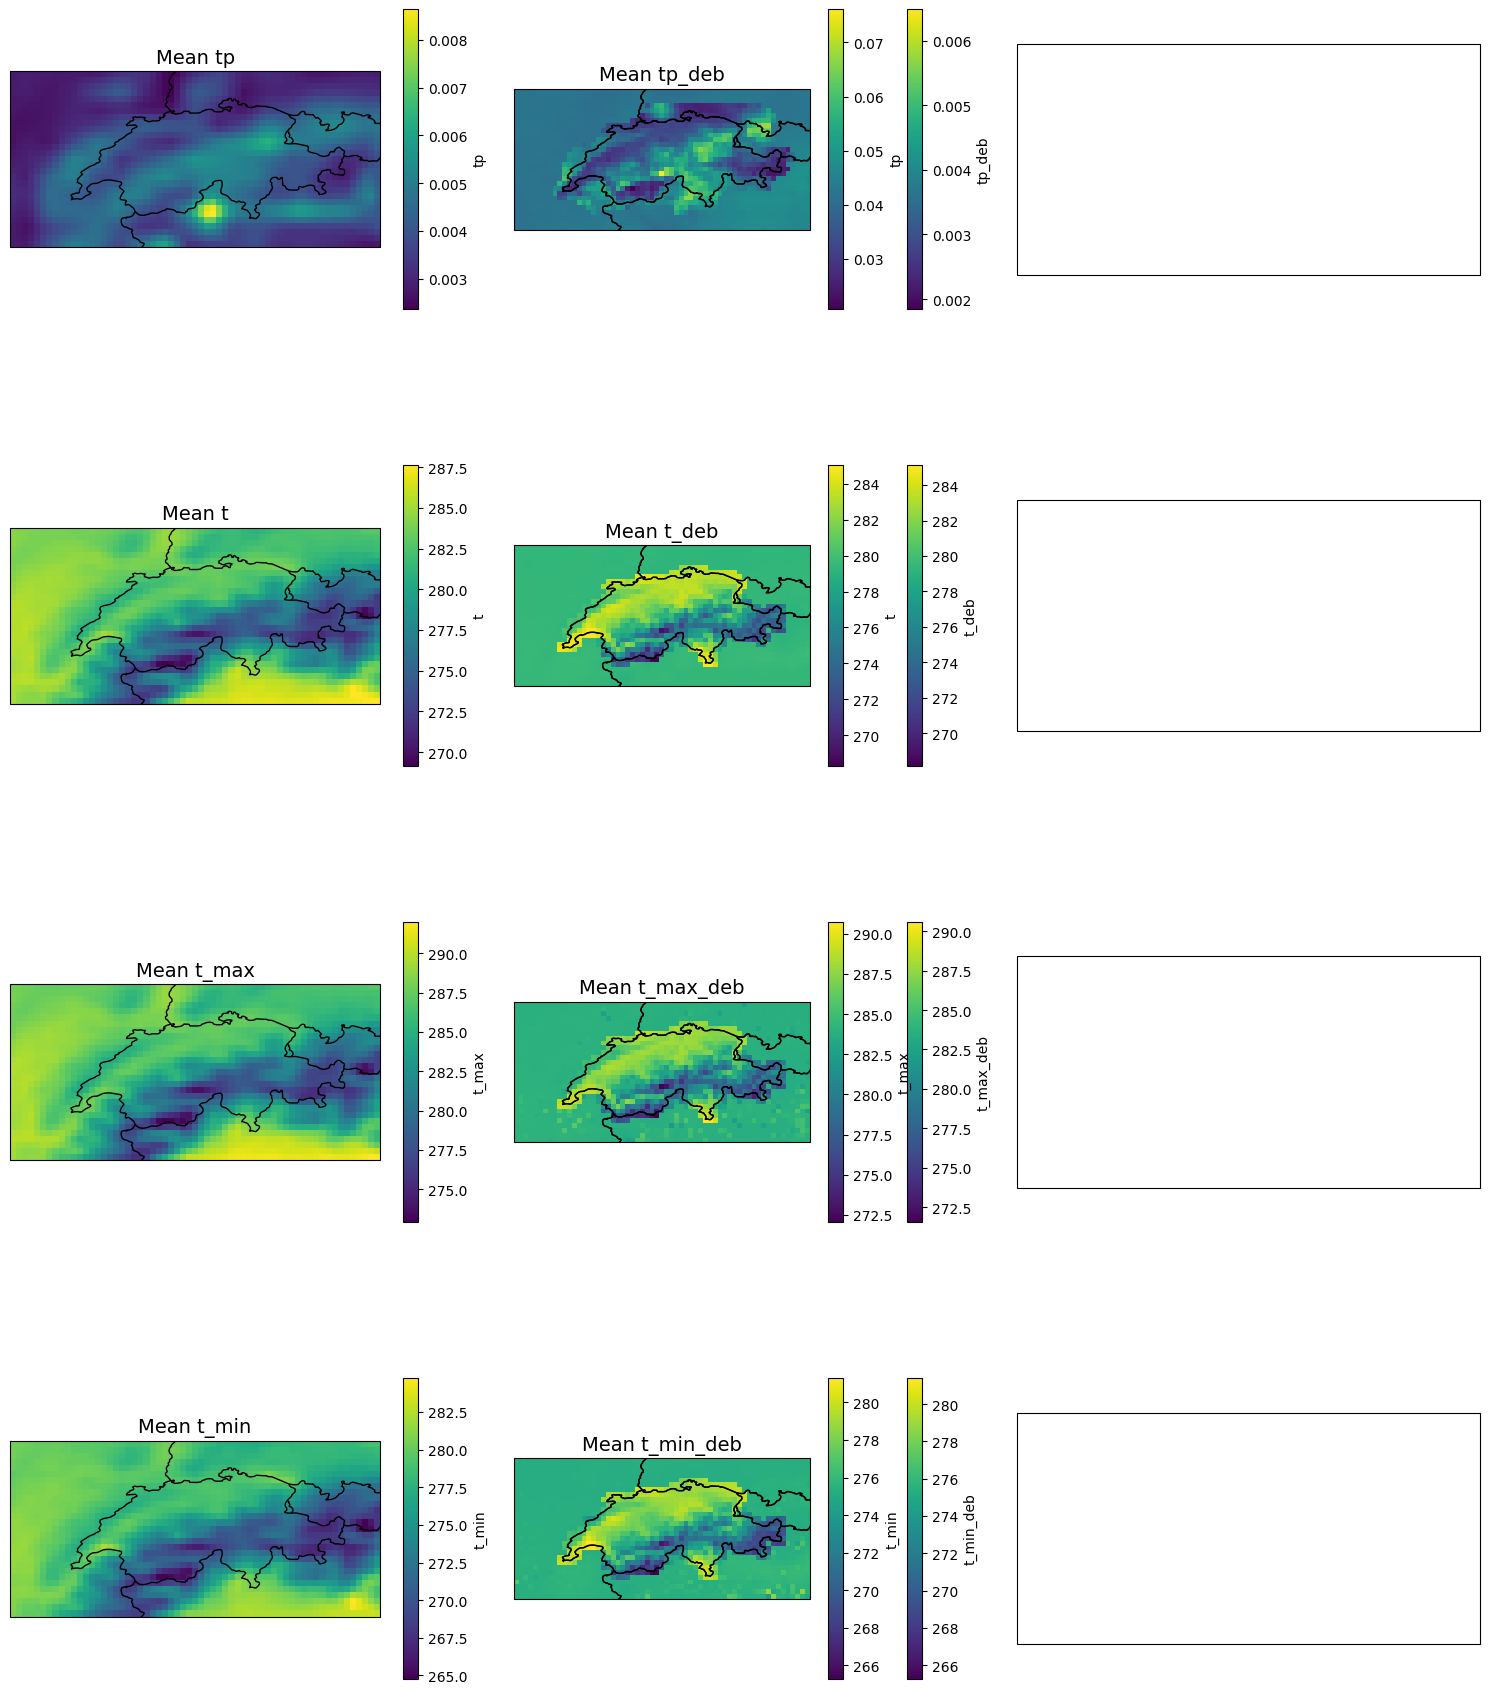

In [40]:
# Define variables to plot
variables = ['tp', 't', 't_max', 't_min']  # Example variables

# Call the function to plot the mean maps
plot_mean_maps(input_data_clim_debiased, variables, target_data_clim)